1.17.0
=== Geometry and Flow ===
L = 14.300 m
Cross-sectional area A = 1.734945e+01 m^2
Q = 4.356e+00 m^3/s

=== Velocities ===
Darcy velocity q = 2.511e-01 cm/s
Pore-water velocity v = 6.277e-01 cm/s
Advective travel time L/v ≈ 22.78 seconds

=== Data Preview ===
   time_sec  C_obs_perc
0      5.33        0.00
1     10.41        0.00
2     15.39        0.13
3     20.32        8.56
4     25.49       27.03
[2.0, 0.1]

=== Fitted Parameters ===
Fitted D = 8.428e-01 cm^2/s
Fitted observations = 129.539 percentage

=== Dimensionless Number ===
Peclet number Pe = 10.65



/tmp/ipykernel_43781/3261532164.py:83: RuntimeWarning: invalid value encountered in sqrt
  C = (M_over_A / (theta * np.sqrt(4 * pi * D * t))) * np.exp(- (L_cm - v * t)**2 / (4 * D * t))


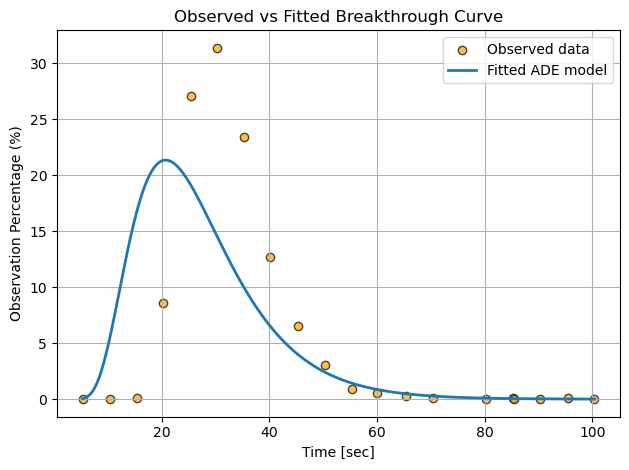

In [25]:
import numpy as np
import pandas as pd
from math import pi
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit

print(scipy.__version__)

# ---------------------------------------------------------------------
# 1. GIVEN EXPERIMENT PARAMETERS
# ---------------------------------------------------------------------
CONC_CONV = 1e-6                    # mg/L to g/mL
INTERVAL = 5.0                      # time interval factor  ie 5 seconds
TIME_CONV = 60.0 / INTERVAL         # min to s
CM_TO_M = 0.01                      # cm to m

# Column geometry
L_cm = 14.3                         # column length [cm]
r_cm = 2.35                          # column diameter [cm]
theta = 0.40                        # porosity or water content (saturated, dimensionless)                # radius [cm]
A = pi * r_cm**2                    # cross-sectional area [cm^2]


# Flow rate
Q_cm3_sec = 4.356                   # volumetric flow rate [cm^3/sec]

print("=== Geometry and Flow ===")
print(f"L = {L_cm:.3f} m")
print(f"Cross-sectional area A = {A:.6e} m^2")
print(f"Q = {Q_cm3_sec:.3e} m^3/s")

# ---------------------------------------------------------------------
# 2. Compute Darcy velocity q and pore-water velocity v
# ---------------------------------------------------------------------

# Darcy velocity q = Q/A
q = Q_cm3_sec / A                   # [cm/s]

# Pore-water (seepage) velocity
v = q / theta                       # [cm/s]


print("\n=== Velocities ===")
print(f"Darcy velocity q = {q:.3e} cm/s")
print(f"Pore-water velocity v = {v:.3e} cm/s")

# Characteristic advective travel time: t_adv = L / v
t_adv_s = L_cm / v                  # [s]
print(f"Advective travel time L/v ≈ {t_adv_s:.2f} seconds")


# ---------------------------------------------------------------------
# 3. Define ADE pulse solution at x = L
# ---------------------------------------------------------------------
df = pd.read_excel("breakthrough_data2.xlsx")

print("\n=== Data Preview ===")
print(df.head())

# Extract data arrays
t_sec = df["time_sec"].values       # time in seconds
C_obs = df["C_obs_perc"].values     # observed concentration by percentage


def C_model(t, D, M_over_A):
    """
    ADE pulse solution at x = L:
    C(L,t) = (M/A) / (theta * sqrt(4*pi*D*t)) * exp( - (L - v*t)^2 / (4*D*t) )

    Parameters
    ----------
    t        : array - Time [s]
    D        : float - Dispersion coefficient [cm^2/s]
    M_over_A : float - Mass per area [mg/m^2]-type units, consistent with data.

    Returns
    -------
    C        : array - Modeled concentration [mg/L].
    """
    t = np.asarray(t)
    # Avoid divide-by-zero (curve_fit will not evaluate exactly at t=0 if we mask)
    C = (M_over_A / (theta * np.sqrt(4 * pi * D * t))) * np.exp(- (L_cm - v * t)**2 / (4 * D * t))
    return C

# ---------------------------------------------------------------------
# 4. Fit D and M/A using curve_fit
# ---------------------------------------------------------------------

# Exclude any t = 0 to avoid numerical issues
mask = t_sec > 0
t_fit = t_sec[mask]
C_fit_obs = C_obs[mask]

# Initial guesses
D_initial = 2.0      # [cm^2/s] rough guess
PER_initial = 0.1     # [mg/m^2] rough guess
p0 = [D_initial, PER_initial]
print(p0)

# Perform nonlinear least squares fit
popt, pcov = curve_fit(C_model, t_fit, C_fit_obs, p0=p0, maxfev=10000)
D_fit, obs = popt

print("\n=== Fitted Parameters ===")
print(f"Fitted D = {D_fit:.3e} cm^2/s")
print(f"Fitted observations = {obs:.3f} percentage")

# ---------------------------------------------------------------------
# 5. Compute Peclet number Pe = v * L / D
# ---------------------------------------------------------------------

Pe = v * L_cm / D_fit
print("\n=== Dimensionless Number ===")
print(f"Peclet number Pe = {Pe:.2f}\n")

# ---------------------------------------------------------------------
# 6. Plot observed vs fitted breakthrough curve
# ---------------------------------------------------------------------

t_plot_s = np.linspace(t_sec.min(), t_sec.max(), 300)
C_model_plot = C_model(t_plot_s, D_fit, obs)

plt.figure()
plt.scatter(t_sec, C_obs, label="Observed data", c="orange", edgecolors='black', alpha=0.7)
plt.plot(t_plot_s, C_model_plot, label="Fitted ADE model", linewidth=2)
plt.xlabel("Time [sec]")
plt.ylabel("Observation Percentage (%)")
plt.title("Observed vs Fitted Breakthrough Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
